### Dependencies

In [1]:
%pip install pandas
%pip install fastparquet
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install keras
%pip install pydot
%pip install seaborn
%pip install scikit-learn
%pip install wandb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Setup

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback

2023-09-07 10:16:50.439816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 10:16:53.515831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 10:16:53.524559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 10:17:13.209095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


- Multiclass (X)
- Multilable (X) -- check how or if to normalize output // select cutoff for predicting charge as present
- Prosit (X)
- Multi-head Binary Classifier (Omar) (TODO)

- Split for all of them (X) 
- Training (X)
- Inference (X?) 
- Analysis (X)
    - TopK
----------------------
----------------------
- Clean up code for presentation (TODO?) 
- Presentation (TODO)

### Data preprocessing
- remove all columns except: 'modified_sequence', 'precursor_charge', 'precursor_intensity'
- filter out unwanted charge states
- filter for most abundant charge state per sequence by precursor_intensity after normalizing the values
- filter sequence length according to occurance in dataset (currently less than 100 sequences of a certain length get removed)
- search for occurences of UNIMOD modifications and add them to the vocabulary
- generate continous sequence encoding // first layer - embedding layer
- generate precursor_charge one-hot encoding

### Preprocessing functions

In [3]:
'''
Combine files into one dataframe and keep only desired columns
Default: 
- dir_path = 'data/'
- file_type = '.parquet'
Default: drop everything except: modified_sequence, precursor_charge and precursor_intensity
- columns_to_keep = ['modified_sequence','precursor_charge','precursor_intensity']
'''
def combine_parquet_into_df(dir_path='data/', file_type='.parquet', columns_to_keep=['modified_sequence','precursor_charge','precursor_intensity']):
    dfs = [] 
    for file in os.listdir(dir_path):
        if file.endswith(file_type):
            file_path = os.path.join(dir_path, file)
            df = pd.read_parquet(file_path, engine='fastparquet')
            df = df[columns_to_keep]
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    return df

In [4]:
'''
Drop all rows with NaN values in a specific column
Default: drop na from precursor_intensity column
'''
def drop_na(df, column='precursor_intensity'):
    df = df[df[column].notna()]
    return df

In [5]:
'''
Keep only desired charge entires
Default: keep charges 1-6
'''
def keep_desired_charges(df, charge_list=[1, 2, 3, 4, 5, 6]):
    df = df[df['precursor_charge'].isin(charge_list)]
    return df

In [6]:
'''
Find all UNIMOD annotations and add them to the vocabulary
(The length of the vocabulary +1 is used later for the embedding layer)
'''
def complete_vocabulary(df):
    """
    Completes the vocabulary with all the possible amino acids and modifications
    :return: list
    """
    vocabulary = []
    vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)
    vocab_len = len(vocabulary)
    return vocabulary, vocab_len

In [7]:
'''
Combine unique sequences and aggregate their precursor_charges and intensity in order to later select the most abundant charge state per sequence.
'''
def aggregate_sequences(df):
    df = df.groupby("modified_sequence")[["precursor_charge", "precursor_intensity"]].agg(list).reset_index()
    return df

In [8]:
# TODO
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
            charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [9]:
# TODO
'''
Select most abundand charge state per unique sequence according to the normalized precursor intensity
'''
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)

In [10]:
# TODO 
'''
One-Hot encode most abundand charge state
'''
def one_hot_encode_charge_states():
    pass

In [11]:
# TODO 
'''
Encode all occuring charge states per unique sequence in a binary vector
'''
def encode_charge_states():
    pass

In [12]:
# TODO 
'''
Filter Sequences 'skipping a charge' eg [1,1,0,1,0,0]
'''
def filter_skipped_charges():
    pass

In [13]:
'''
Find the maximum sequence length in the dataset
'''
max_seq_len = 0 

def find_max_seq_len(df):
    max_seq_len = 0
    if max_seq_len < df['modified_sequence'].str.len().max():
        max_seq_len = df['modified_sequence'].str.len().max()
    return max_seq_len

In [14]:
# TODO
'''
Define sequence length cutoff. 
Remove sequences of a certain length if there aren't enough of them (at least k)
'''
def seq_len_cutoff(df, k):
    df['seq_len_prepadding'] = df['modified_sequence'].apply(lambda x: len(x))
    len_counts = df['seq_len_prepadding'].value_counts()
    

In [15]:
# TODO
'''
Encode modified_sequence column into a vector of integers
'''
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 10

def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]



def modified_sequence_encoder(max_len=max_len_seq):
    """
    Encodes the modified_sequence column into a vector of integers
    :return: list
    """
    max_len_seq = max([len(seq) for seq in df['modified_sequence']])
    return [seq_translator(seq) for seq in df['modified_sequence']]

## Preprocessing

In [16]:
dir_path = 'data/'
file_type = '.parquet'
max_seq_len = 0

In [17]:
df = combine_parquet_into_df(dir_path, file_type)

In [18]:
df = drop_na(df, 'precursor_intensity')

In [19]:
df = keep_desired_charges(df)

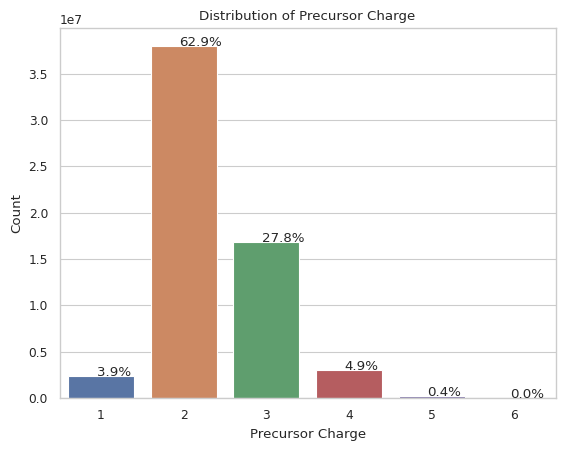

In [27]:
# plot the distirbution of precursor_charge for the whole dataset
# add percentage of each charge state to the plot
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.countplot(x='precursor_charge', data=df)
# add title and axis labels
plt.xlabel('Precursor Charge')
plt.ylabel('Count')
plt.title('Distribution of Precursor Charge')
# add percentage of each charge state to the plot
total = len(df['precursor_charge'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 5
    ax.annotate(percentage, (x, y))

In [21]:
vocabulary, voc_len = complete_vocabulary(df)

In [22]:
df = aggregate_sequences(df)

In [23]:
df.head()

,modified_sequence,precursor_charge,precursor_intensity
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300...."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4..."


## Ziel sind Funktionen die jeweils den df nehmen und wieder einen df ausspucken so dass man am ende keine einzelnen Code-Abschnitte mehr im Ablauf hat und evtl für multiclass und multilable nur den ablauf an funktionen ändern muss

In [ ]:
# TODO: rewrite normalization and finding of most abundant charge state into a function taking df and returning df
# df = find_most_abundant_charge(df)

In [ ]:
# TODO: write function to one hot encode most abunant charge state in df

In [35]:
# TODO: filter sequence lengths with too little representation and take longest sequence with still enough representation as padding length

max_seq_len = find_max_seq_len(df)

In [18]:
# TODO: encode modified sequence wth padding to previously determined max_seq_len

# df = modified_sequence_encoder(df['modified_sequence'], max_seq_len, 'modified_sequence_vector')

In [ ]:
# TODO: 

# Models

General idea:
Input: mod_seq_encoded, precursor_charge // precursor_charge_onehot
Output: 5 nodes --> highest value == most probable charge for input sequence
Use: Softmax, Crossentropy loss

stratified split:
- PROSITE
- CCE
- SCCE // ?

evaluate models by:
- categorical accuracy
- f1 score // ?

#### Stratified split for all models
Split into train_val and test by unique sequence 

Split into train and val via stratified split

In [41]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#### CCE

In [46]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Input

inputA_embed = Input(shape=train_ds_embed[0].shape)
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
y = Dense(max_len_seq, activation="relu")(y)
z = Dense(num_classes, activation="softmax")(y)
multiclass_model = Model(inputs=[x.input], outputs=z)

In [ ]:
multiclass_model.summary()

In [ ]:
tf.keras.utils.plot_model(multiclass_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Define callbacks for multiclass model
checkpoint_callback_multiclass_model = ModelCheckpoint('checkpoints/multiclass_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_multiclass_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
multiclass_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [ ]:
# training with stratified split
# save history of model training
history_multiclass_model = multiclass_model.fit(train_ds_embed, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()])

### Anaylsis / Plots etc.

In [49]:
# eval

## Postprocessing

In [35]:
def generate_charge_prediction_text(charge_predictions):
    max_charge_index = np.argmax(charge_predictions)
    max_charge_value = round(charge_predictions[max_charge_index], 2)

    charge_text = f"The predicted charge state for the input sequence is {max_charge_index+1} [{round(max_charge_value*100,2)}%]."
    percentage_text = "Prediction percentages for other states:\n"

    for index, prediction in enumerate(charge_predictions):
        if index != max_charge_index:
            percentage = round(prediction * 100, 2)
            percentage_text += f"Charge state {index+1}: {percentage}%\n"

    full_text = charge_text + "\n" + percentage_text
    return full_text


# Beispiel
charge_predictions = np.array([0, 0.3, 0.53, 0.17, 0, 0])
output_text = generate_charge_prediction_text(charge_predictions)
print(output_text)

The predicted charge state for the input sequence is 3 [53.0%].
Prediction percentages for other states:
Charge state 1: 0.0%
Charge state 2: 30.0%
Charge state 4: 17.0%
Charge state 5: 0.0%
Charge state 6: 0.0%

